# Guiding VQGAN for fMRI reconstruction

This notebook explores the NSD dataset and attempts to train a ViTGAN generator to predict the latent code `z` from the fMRI voxel signal for the VQGAN to reconstruct the stimulus image seen by the patient whose fMRI is recorded.

## Imports:

In [1]:
import numpy as np
import os
import h5py
from PIL import Image
from omegaconf import OmegaConf
from taming.models import vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torchvision.transforms import functional as TF
from vitgan import Generator
from tqdm.auto import tqdm

## Exploratory Data Analysis

In [2]:
os.listdir('/mnt/tmabraham/data/LAION-medical/fMRI')

['subj01_nsdgeneral.npz', 'subj01_nsdgeneral.hdf5']

HDF5 format is faster to load.

In [3]:
f = h5py.File('/mnt/tmabraham/data/LAION-medical/fMRI/subj01_nsdgeneral.hdf5', 'r')
voxels = f['subj01/voxels']
images = f['subj01/images']
print(voxels.shape, images.shape) # (22750, 15724) (27750, 256, 256, 3)

(27750, 15724) (27750, 256, 256, 3)


For this subject, there are 27750 trials and the voxel signal has been flattened into a vector of length 15724. Let's look at an example image:

In [4]:
image = images[0].astype(np.uint8)

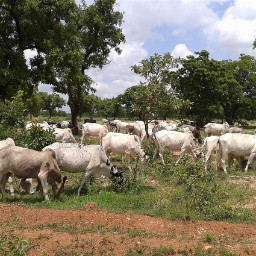

In [5]:
image_pil = Image.fromarray(image)
image_pil

## VQGAN guiding:

Much of the code is taken from the [VQGAN-CLIP](https://github.com/EleutherAI/vqgan-clip/) and [Feedforward VQGAN-CLIP](https://github.com/mehdidc/feed_forward_vqgan_clip) repositories.

VQGAN loading code:

In [6]:
def load_vqgan_model(config_path):
    global gumbel
    config = OmegaConf.load(config_path)
    checkpoint_path = config.model.params.ckpt_path
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
        gumbel = True
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

Perceptual loss (not being used right now):

In [7]:
class VGG(nn.Module):
    """VGG/Perceptual Loss
    
    Parameters
    ----------
    conv_index : str
        Convolutional layer in VGG model to use as perceptual output

    """
    def __init__(self, conv_index: str = '22'):

        super(VGG, self).__init__()
        vgg_features = torchvision.models.vgg19(pretrained=True).features
        modules = [m for m in vgg_features]
        
        if conv_index == '22':
            self.vgg = nn.Sequential(*modules[:8])
        elif conv_index == '54':
            self.vgg = nn.Sequential(*modules[:35])

        vgg_mean = (0.485, 0.456, 0.406)
        vgg_std = (0.229, 0.224, 0.225)
        #self.sub_mean = common.MeanShift(rgb_range, vgg_mean, vgg_std)
        self.vgg.requires_grad = False
    
    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        def _forward(x):
            #x = self.sub_mean(x)
            x = self.vgg(x)
            return x
            
        vgg_input = _forward(input)

        with torch.no_grad():
            vgg_target = _forward(target.detach())

        loss = F.mse_loss(vgg_input, vgg_target)

        return loss

Code for synthesizing an image with VQGAN from a given latent vector:

In [8]:
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


replace_grad = ReplaceGrad.apply

class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None


clamp_with_grad = ClampWithGrad.apply

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)

def synth(model, z):
    # if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        # z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
    # else:
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    x  = clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)
    return x


In [9]:
device = torch.device(3)

Load model:

In [10]:
model = load_vqgan_model('checkpoints/coco_vqgan.yaml').to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from checkpoints/coco_epoch117.ckpt
Restored from checkpoints/coco_epoch117.ckpt


In [11]:
f = 2**(model.decoder.num_resolutions - 1)

In [12]:
toksX, toksY = image.shape[0] // f, image.shape[1] // f
sideX, sideY = toksX * f, toksY * f

In [13]:
e_dim = model.quantize.e_dim
n_toks = model.quantize.n_e
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

In [14]:
vq_channels = model.quantize.embedding.weight.shape[1]

Example of getting the latent vector for an image:

In [15]:
img = Image.fromarray(image)
pil_image = img.convert('RGB')
pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
pil_tensor = TF.to_tensor(pil_image)
z, *_ = model.encode(pil_tensor.to(device).unsqueeze(0) * 2 - 1)

In [16]:
z.shape

torch.Size([1, 256, 16, 16])

Example of generating image from latent vector:

In [17]:
pred_image = synth(model, z)

In [18]:
def img_to_pil(img): return Image.fromarray((255*img).permute(0,2,3,1)[0].detach().cpu().numpy().astype(np.uint8))

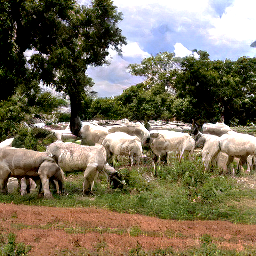

In [19]:
img_to_pil(pred_image)

Compare to original:

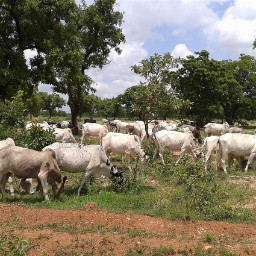

In [20]:
image_pil

Variables for ViTGAN generator arch:

In [21]:
vq_image_size = 16
dropout = 0
dim = 128
num_heads = 6
depth = 8

In [22]:
net = Generator(
    initialize_size = vq_image_size//8, 
    dropout = dropout, 
    out_channels=vq_channels,
    input_dim=15724,
    dim=dim,
    num_heads=num_heads,
    blocks=depth,
).to(device)

NSD Image PyTorch Dataset:

In [23]:
class NSDImageDataset(torch.utils.data.Dataset):
    def __init__(self, voxels, images):
        super(NSDImageDataset, self).__init__()
        assert len(voxels) == len(images)
        self.voxels = voxels
        self.images = images
        
    def __len__(self):
        return len(self.voxels)
    
    def __getitem__(self, idx):
        voxel = self.voxels[idx]
        image = self.images[idx].astype(np.uint8)
        image = TF.to_tensor(image)*2 - 1.
        return {'voxel': voxel, 'image': image}

Create dataset:

In [24]:
train_voxels, train_images = voxels[:len(voxels)-750], images[:len(images)-750]
valid_voxels, valid_images = voxels[len(voxels)-750:], images[len(images)-750:]

train_dataset = NSDImageDataset(train_voxels, train_images)
valid_dataset = NSDImageDataset(valid_voxels, valid_images)

batch_size = 128

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=True, num_workers=8)

Train and evaluation loop:

In [25]:
def train_loop(model, net, train_dl, loss_func, optimizer, lr_scheduler, device):
    for i, batch in enumerate(tqdm(train_dl)):
        voxels = batch['voxel'].to(device)
        images = batch['image'].to(device)
        
        z_pred = net(voxels)
        z_pred = clamp_with_grad(z_pred, z_min.min(), z_max.max())
        
        #images_pred = synth(model, z_pred)
        z, *_ = model.encode(images)
        
        #loss = loss_func(images_pred, images)
        loss = loss_func(z_pred, z)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()


def eval_loop(model, net, valid_dl, loss_func, optimizer, lr_scheduler, device):
    losses = []
    for i, batch in enumerate(tqdm(valid_dl)):
        voxels = batch['voxel'].to(device)
        images = batch['image'].to(device)
        
        with torch.no_grad():
            z_pred = net(voxels)
            z_pred = clamp_with_grad(z_pred, z_min.min(), z_max.max())
            z, *_ = model.encode(images)
            #images_pred = synth(model, z_pred)
            #loss = loss_func(images_pred, images)
            loss = loss_func(z_pred, z)
            losses.append(loss.cpu())
        
    print(f'Loss: {np.mean(losses)}')

More hyperparameters:

In [26]:
epochs = 10
lr = 3e-4

In [27]:
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

In [28]:
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dl))

In [29]:
#loss_func = VGG().to(device)

In [30]:
def loss_func(z_pred, z):
    loss = F.mse_loss(z_pred,z)
    loss += 0*(z_pred**2).mean() # do we need l2 regularization?
    return loss

## Train model:

In [31]:
for epoch in range(epochs):
    print(f'Training Epoch {epoch}')
    train_loop(model, net, train_dl, loss_func, optimizer, lr_scheduler, device)
    print(f'Validation')
    eval_loop(model, net, valid_dl, loss_func, optimizer, lr_scheduler, device)

Training Epoch 0


  0%|          | 0/211 [00:03<?, ?it/s]

Validation


  0%|          | 0/6 [00:02<?, ?it/s]

Loss: 25.094453811645508
Training Epoch 1


  0%|          | 0/211 [00:02<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f373cda80d0>
Traceback (most recent call last):
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f373cda80d0>
Traceback (most recent call last):
Exception ignored in:   File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 

Validation


  0%|          | 0/6 [00:02<?, ?it/s]

Loss: 24.74393653869629
Training Epoch 2


  0%|          | 0/211 [00:02<?, ?it/s]

Validation


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/queues.py", line 241, in _feed
    close()
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/connection.py", line 366, in _close
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/queues.py", line 241, in _feed
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    close()
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/connection.py", line 182, in

  0%|          | 0/6 [01:12<?, ?it/s]

Loss: 23.95709991455078
Training Epoch 3


  0%|          | 0/211 [00:02<?, ?it/s]

Validation


  0%|          | 0/6 [00:02<?, ?it/s]

Loss: 22.068483352661133
Training Epoch 4


  0%|          | 0/211 [00:02<?, ?it/s]

Validation


  0%|          | 0/6 [00:02<?, ?it/s]

Loss: 13.524313926696777
Training Epoch 5


  0%|          | 0/211 [00:02<?, ?it/s]

Validation


  0%|          | 0/6 [00:02<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f373cda80d0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f373cda80d0>  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__

      File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers

      File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
asse

Loss: 5.4774909019470215
Training Epoch 6


  0%|          | 0/211 [00:02<?, ?it/s]

Validation


  0%|          | 0/6 [00:02<?, ?it/s]

Loss: 0.8487482666969299
Training Epoch 7


  0%|          | 0/211 [00:02<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/queues.py", line 241, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/queues.py", line 241, in _feed
    close()
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/connection.py", line 182, in close
    close()
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/connection.py", line 366, in _close
    self._close()
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Trac

Validation


  0%|          | 0/6 [00:02<?, ?it/s]

Loss: 3.6308534145355225
Training Epoch 8


  0%|          | 0/211 [00:02<?, ?it/s]

Validation


  0%|          | 0/6 [00:02<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f373cda80d0>Traceback (most recent call last):
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f373cda80d0>
Traceback (most recent call last):
  File "/home/tmabraham/anaconda3/envs/fMRI/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/home/tmabraham/anaconda3/envs/fMRI/l

Loss: 0.6603122353553772
Training Epoch 9


  0%|          | 0/211 [00:02<?, ?it/s]

Validation


  0%|          | 0/6 [00:02<?, ?it/s]

Loss: 3.5582921504974365


## Evaluate model:

In [32]:
i = 99
image, voxel = valid_dataset[i]['image'], valid_dataset[i]['voxel']

In [33]:
z_pred = net(torch.Tensor(voxel).unsqueeze(0).to(device))

In [34]:
z_pred = clamp_with_grad(z_pred, z_min.min(), z_max.max())

In [35]:
pred_img = synth(model, z_pred)

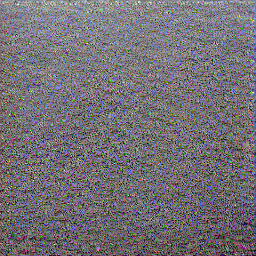

In [36]:
img_to_pil(pred_img)

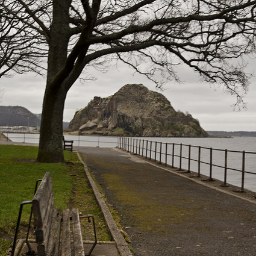

In [37]:
Image.fromarray((255*(image+1)/2).permute(1,2,0).numpy().astype(np.uint8))

In [38]:
image.shape

torch.Size([3, 256, 256])

In [39]:
z, *_ = model.encode(image.to(device).unsqueeze(0))

In [40]:
z = clamp_with_grad(z, z_min.min(), z_max.max())

In [41]:
decoded_img = synth(model, z)

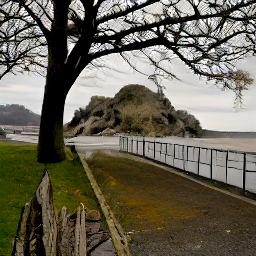

In [42]:
img_to_pil(decoded_img)

In [43]:
loss_func(z_pred, z)

tensor(3.0739, device='cuda:3', grad_fn=<AddBackward0>)